<a href="https://colab.research.google.com/github/SalsiYari/ImgDatasetGenerator/blob/main/CLIP_L14_zero_shot_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Zero-shot Benchmark — CLIP ViT-L/14 (open_clip)

Questo notebook è **pronto per la comparazione** tra modelli/approcci sul task di *architectural style classification*.
È pensato per Colab + Google Drive e registra le metriche nel formato della tua **scorecard**.

### Cosa fa
- Carica **CLIP ViT-L/14 (openai)** via `open_clip`
- Esegue **zero-shot** su un dataset organizzato a cartelle (`train/`, `valid/`, `test/`)
- Calcola: **Top-1**, **Macro-F1**, **Top-5**, **Latency (ms/img)**
- Registra anche: **GPU-h** (*0.0 in zero-shot*), **Effort umano (h)** (manuale), **Note**
- Esporta un **CSV** `benchmark_results.csv` con una riga per questa esecuzione

> Modifica solo le variabili nella sezione **Config** qui sotto (path in Drive, split, ecc.).


In [ ]:

# === Install ===
!pip -q install open_clip_torch scikit-learn matplotlib pandas tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00


In [ ]:

# === Imports & Config ===
import os, time, json, math
from datetime import datetime
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import open_clip
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, top_k_accuracy_score, f1_score
import matplotlib.pyplot as plt

# Colab + Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --------- CONFIG (MODIFICA QUI) ---------
DATA_ROOT = "/content/drive/MyDrive/ArchiStyles-2"  # cartella dataset
SPLIT = "test"  # "test" | "valid" | "train"
BATCH_SIZE = 64

# Modello
MODEL_NAME = "ViT-L-14"   # "ViT-L-14" oppure "ViT-L-14-336"
PRETRAINED = "openai"     # per L/14 e L/14-336 usare "openai"

# Prompt templates (puoi aggiungere/variare)
TEMPLATES = [
    "a photo of a {} building",
    "a photograph of {} architecture",
    "an example of {} architecture",
    "a building in {} style",
]
# Effort & note per la scorecard
EFFORT_HOURS = 0.5   # inserisci stima ore uomo per questa run (setup+tuning)
NOTES = "zero-shot baseline L/14 with prompt ensemble + temperature grid"
# -----------------------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Mounted at /content/drive
Using device: cuda


In [ ]:

# === Model & Dataset ===
# Modello + preprocess
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name=MODEL_NAME,
    pretrained=PRETRAINED
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
model.to(device).eval()

# Dataset + DataLoader
assert os.path.isdir(DATA_ROOT), f"DATA_ROOT non trovato: {DATA_ROOT}"
split_path = os.path.join(DATA_ROOT, SPLIT)
assert os.path.isdir(split_path), f"Split '{SPLIT}' non trovato in {DATA_ROOT}"
ds = ImageFolder(split_path, transform=preprocess)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
classnames = ds.classes
num_classes = len(classnames)

print("Classi:", num_classes)
print("Esempio classi:", classnames[:10])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Classi: 25
Esempio classi: ['Achaemenid', 'American Foursquare', 'American craftsman style', 'Ancient Egyptian', 'Art Deco', 'Art Nouveau', 'Baroque', 'Bauhaus', 'Beaux-Arts', 'Byzantine']


In [ ]:

# === Prompt generation & temperature scaling ===
def make_prompts(cname):
    return [t.format(cname) for t in TEMPLATES] + [f"{cname} architecture"]

# Tokenize prompts (prompt ensemble)
all_prompts, class_offsets = [], [0]
for cname in classnames:
    ps = make_prompts(cname)
    all_prompts.extend(ps)
    class_offsets.append(len(all_prompts))

tokens = tokenizer(all_prompts).to(device)

# Encode text once
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# Grid semplice per temperature (moltiplica i logits)
TEMP_GRID = [0.5, 1.0, 2.0]  # puoi estendere


In [ ]:

# === Inference (with temperature search) ===
def evaluate_with_temp(temp):
    y_true, y_pred = [], []
    probs_collector = []
    model_dtype = next(model.parameters()).dtype

    with torch.no_grad():
        for imgs, labels in dl:
            imgs = imgs.to(device, dtype=model_dtype)
            img_features = model.encode_image(imgs)
            img_features = img_features / img_features.norm(dim=-1, keepdim=True)

            # logit scale nativo * temperature custom
            logit_scale = model.logit_scale.exp() * temp
            logits = logit_scale * (img_features @ text_features.T)

            # aggrega prompt per classe
            class_logits = []
            for i in range(num_classes):
                s, e = class_offsets[i], class_offsets[i+1]
                class_logits.append(logits[:, s:e].mean(dim=1))
            class_logits = torch.stack(class_logits, dim=1)

            prob = class_logits.softmax(dim=-1)
            pred = prob.argmax(dim=-1)

            y_true.extend(labels.tolist())
            y_pred.extend(pred.tolist())
            probs_collector.append(prob.cpu().numpy())

    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)
    probs = np.concatenate(probs_collector, axis=0)

    top1 = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    top5 = top_k_accuracy_score(y_true, probs, k=min(5, num_classes), labels=np.arange(num_classes))

    return top1, macro_f1, top5, y_true, y_pred, probs

# Cerchiamo la temperatura migliore sullo split usato (nota: per rigore, farlo su VALID)
best = None
for t in TEMP_GRID:
    top1, macro_f1, top5, _, _, _ = evaluate_with_temp(t)
    print(f"temp={t:.2f} -> top1={top1:.4f}  macroF1={macro_f1:.4f}  top5={top5:.4f}")
    if best is None or top1 > best[0]:
        best = (top1, macro_f1, top5, t)

best_top1, best_macro_f1, best_top5, best_temp = best
print("\nBest temperature:", best_temp)


temp=0.50 -> top1=0.5780  macroF1=0.5636  top5=0.8777
temp=1.00 -> top1=0.5780  macroF1=0.5636  top5=0.8777
temp=2.00 -> top1=0.5780  macroF1=0.5636  top5=0.8777

Best temperature: 0.5


In [ ]:

# === Final evaluation with best temperature & latency measurement ===
# Recompute to get y_true/y_pred/probs with best_temp
top1, macro_f1, top5, y_true, y_pred, probs = evaluate_with_temp(best_temp)

# Latency (ms/img) misurata su alcuni batch reali
def measure_latency(num_batches=20):
    model_dtype = next(model.parameters()).dtype
    # warmup
    it = iter(dl)
    for _ in range(3):
        try:
            imgs, _ = next(it)
        except StopIteration:
            it = iter(dl)
            imgs, _ = next(it)
        imgs = imgs.to(device, dtype=model_dtype)
        with torch.no_grad():
            _ = model.encode_image(imgs)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # timed
    times = []
    it = iter(dl)
    for _ in range(num_batches):
        try:
            imgs, _ = next(it)
        except StopIteration:
            it = iter(dl)
            imgs, _ = next(it)
        imgs = imgs.to(device, dtype=model_dtype)
        t0 = time.time()
        with torch.no_grad():
            _ = model.encode_image(imgs)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        dt = time.time() - t0
        ms_per_img = (dt / imgs.size(0)) * 1000.0
        times.append(ms_per_img)
    return float(np.mean(times))

latency_ms = measure_latency(num_batches=min(20, math.ceil(len(ds)/BATCH_SIZE)))

# GPU-h (zero-shot): 0.0
gpu_hours = 0.0

print(f"FINAL -> Top-1={top1:.4f} | Macro-F1={macro_f1:.4f} | Top-5={top5:.4f}")
print(f"Latency: {latency_ms:.1f} ms/img | GPU-h: {gpu_hours:.2f}")



FINAL -> Top-1=0.5780 | Macro-F1=0.5636 | Top-5=0.8777
Latency: 43.0 ms/img | GPU-h: 0.00


In [ ]:

# === Save results row to CSV ===
row = {
    "Timestamp": datetime.utcnow().isoformat(),
    "Model": MODEL_NAME,
    "Pretrained": PRETRAINED,
    "Scenario": f"Zero-shot ({SPLIT})",
    "Techniques": "Prompt ensemble + temperature search",
    "Top-1 Acc": round(float(top1), 4),
    "Macro-F1": round(float(macro_f1), 4),
    "Top-5 Acc": round(float(best_top5), 4),
    "GPU-h": gpu_hours,
    "Latency (ms/img)": round(float(latency_ms), 1),
    "Effort umano (h)": float(EFFORT_HOURS),
    "Note": NOTES,
    "Classes": int(len(classnames)),
    "Batch size": int(BATCH_SIZE)
}

df = pd.DataFrame([row])
display(df)

# Salva in locale e (opzionale) in Drive
csv_path_local = "/content/benchmark_results.csv"
if os.path.exists(csv_path_local):
    old = pd.read_csv(csv_path_local)
    out = pd.concat([old, df], ignore_index=True)
else:
    out = df.copy()
out.to_csv(csv_path_local, index=False)

# Salva anche nella cartella del dataset su Drive
csv_path_drive = os.path.join(DATA_ROOT, "benchmark_results.csv")
try:
    if os.path.exists(csv_path_drive):
        old_d = pd.read_csv(csv_path_drive)
        out_d = pd.concat([old_d, df], ignore_index=True)
    else:
        out_d = df.copy()
    out_d.to_csv(csv_path_drive, index=False)
    print("Saved CSV to:", csv_path_local, "and", csv_path_drive)
except Exception as e:
    print("Saved CSV to:", csv_path_local)
    print("Drive save failed:", e)


/tmp/ipython-input-275238621.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "Timestamp": datetime.utcnow().isoformat(),


,Timestamp,Model,Pretrained,Scenario,Techniques,Top-1 Acc,Macro-F1,Top-5 Acc,GPU-h,Latency (ms/img),Effort umano (h),Note,Classes,Batch size
0,2025-08-20T14:30:09.776641,ViT-L-14,openai,Zero-shot (test),Prompt ensemble + temperature search,0.578,0.5636,0.8777,0.0,43.0,0.5,zero-shot baseline L/14 with prompt ensemble +...,25,64


Saved CSV to: /content/benchmark_results.csv and /content/drive/MyDrive/ArchiStyles-2/benchmark_results.csv


Accuracy: 0.5780
                          precision    recall  f1-score   support

              Achaemenid     1.0000    0.8788    0.9355        33
     American Foursquare     0.2838    0.7500    0.4118        28
American craftsman style     0.3947    0.6000    0.4762        25
        Ancient Egyptian     0.8438    1.0000    0.9153        27
                Art Deco     0.6471    0.6286    0.6377        35
             Art Nouveau     0.8571    0.7500    0.8000        24
                 Baroque     0.6000    0.1935    0.2927        31
                 Bauhaus     0.5833    0.6087    0.5957        23
              Beaux-Arts     0.5556    0.1429    0.2273        35
               Byzantine     0.8947    0.6071    0.7234        28
          Chicago school     0.4545    0.5357    0.4918        28
                Colonial     0.7500    0.4000    0.5217        30
        Deconstructivism     0.9062    0.8529    0.8788        34
               Edwardian     0.7391    0.5862    0.6538   

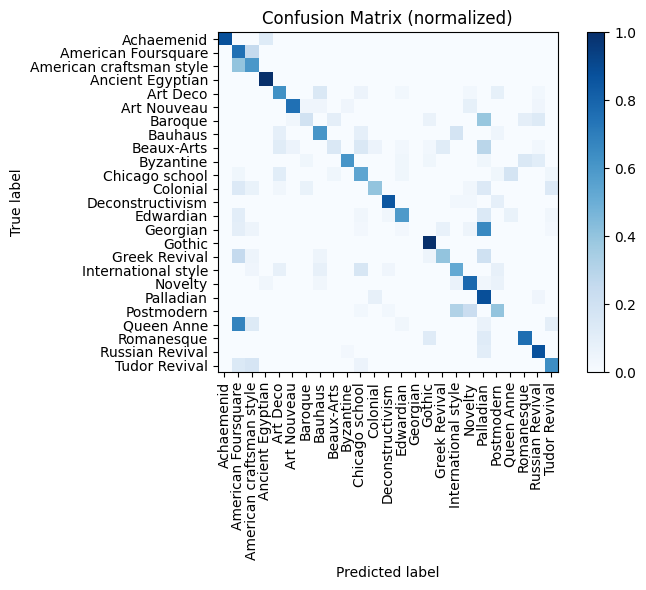

In [11]:
#metriche per analisi FINE_GRADIENT ("dove sbaglia il modello?")

#1.Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

#2.Macro-F1
macro_f1 = f1_score(y_true, y_pred, average="macro")

#2. Report dettagliato (precision, recall, F1 per classe)
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classnames, digits=4 , zero_division=0))

# 3. Accuracy@K
from sklearn.metrics import top_k_accuracy_score

for k in [1,2,3,5]:
    print(f"Top-{k} Accuracy:",
          top_k_accuracy_score(y_true, probs, k=k, labels=range(len(classnames))))

#matrice di confuzione
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    top_k_accuracy_score, ConfusionMatrixDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix (normalizzata)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=classnames,
    normalize="true",           # percentuali per riga
    cmap="Blues",
    include_values=False,       # evita numeri sopra le celle se hai tante classi
    xticks_rotation=90,
    ax=ax,
    colorbar=True
)
ax.set_title("Confusion Matrix (normalized)")
plt.tight_layout()
plt.show()